* notebook created by nov05 on 2024-12-01  
* local conda env [`awsmle_py310`](https://gist.github.com/nov05/d9c3be6c2ab9f6c050e3d988830db08b) (no cuda)    

* train and deploy scripts  
  ```text
  repo/  
  │  
  ├── 02.train_hpo_debug_deploy.ipynb (this notebook)  
  ├── scripts/  
  │   ├── train.py  
  │   └── requirements.txt    
  └── deploy_scripts/   
      └── inference.py       
  ```
---   

* https://sagemaker.readthedocs.io/en/v2.34.0/frameworks/pytorch/sagemaker.pytorch.html   
* https://docs.wandb.ai/guides/integrations/sagemaker/  

In [ ]:
# TODO: Install any packages that you might need
# !pip install smdebug

## **AWS credentials and roles**

In [2]:
## windows cmd to launch notepad to edit aws credential file
!notepad C:\Users\guido\.aws\credentials

In [1]:
## reset the session after updating credentials
import boto3 # type: ignore
boto3.DEFAULT_SESSION = None
import sagemaker # type: ignore
from sagemaker import get_execution_role # type: ignore

role_arn = get_execution_role()  ## get role ARN
if 'AmazonSageMaker-ExecutionRole' not in role_arn:
    ## Go to "IAM - Roles", search for "SageMaker", find the execution role.
    voclabs_role_arn = role_arn
    role_arn = "arn:aws:iam::852125600954:role/service-role/AmazonSageMaker-ExecutionRole-20241119T203081"
print("Role ARN:", role_arn) ## If local, Role ARN: arn:aws:iam::807711953667:role/voclabs
session = sagemaker.Session()
region = session.boto_region_name
bucket = session.default_bucket()
print("AWS Region: {}".format(region))
print("Default Bucket: {}".format(bucket))
print("Role ARN: {}".format(role_arn))
print(f"Role voclabs ARN: {voclabs_role_arn}")

import wandb
## generate secrets.env. remember add it to .gitignore  
wandb.sagemaker_auth(path="scripts")  

d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\pydantic\_internal\_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[12/06/24 03:45:49] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=128720;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=612966;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\guido\AppData\Local\sagemaker\sagemaker\config.yaml


[12/06/24 03:45:50] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=328612;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=648576;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[12/06/24 03:45:52] WARNING  Couldn't call 'get_role' to get Role ARN from role name voclabs to get ]8;id=827968;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=950316;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#5902\5902]8;;\
                             Role path.                                                                            

Role ARN: arn:aws:iam::852125600954:role/service-role/AmazonSageMaker-ExecutionRole-20241119T203081


                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=870394;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=398775;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

AWS Region: us-east-1
Default Bucket: sagemaker-us-east-1-852125600954
Role ARN: arn:aws:iam::852125600954:role/service-role/AmazonSageMaker-ExecutionRole-20241119T203081
Role voclabs ARN: arn:aws:iam::852125600954:role/voclabs


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## **Dataset**  
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.  
* Refer to the `00.EDA.ipynb` file.  

In [1]:
#TODO: Fetch and upload the data to AWS S3
# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

## **Training**

In [5]:
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
from datetime import datetime
## Moving the 1.1GB data from one bucket to another takes 1 hours.
## This is roughly the same amount of time as uploading the data from a local machine to S3.
data_base_path = "s3://p3-dog-breed-image-classification/dogImages/"
train_data = TrainingInput(data_base_path+"train/", content_type="image/jpeg")
val_data = TrainingInput(data_base_path+"valid/", content_type="image/jpeg")
test_data = TrainingInput(data_base_path+"test/", content_type="image/jpeg")
##  ⚠️ don't use prefix in output_path, cause source folder will be created 
## at bucket level while other folders, e.g. debug-output, at prefix levle.
output_path = "s3://p3-dog-breed-image-classification/"  

In [ ]:
# hyperparameters = {
#     'epochs': 40,  # Define how many epochs you want to train for
#     'batch-size': 64,  ## ⚠️ this probably needs to be small for smaller training dataset?
#     'opt-learning-rate': 1e-5,  ## optimizer lr. ⚠️ keep it small for pre-trained model
#     'opt-weight-decay': 1e-4, ## optimizer weight decay
#     'model-type': 'resnet50',  # Specify the ResNet model type you want to use
# }
# Define the PyTorch estimator
# estimator = PyTorch(
#     entry_point='train.py',  # Your training script that defines the ResNet50 model and training loop
#     source_dir='scripts',  # Directory where your script and dependencies are stored
#     role=role_arn,
#     framework_version='1.13.1',  # Use the PyTorch version you need
#     py_version='py39',
#     instance_count=1,  # Adjust based on the number of instances you want to use
#     # instance_type='ml.p3.2xlarge',  # 16GB, Use GPU instances for deep learning
#     instance_type='ml.g4dn.xlarge',  ## 16GB
#     output_path=output_path,
#     hyperparameters=hyperparameters,
#     # use_spot_instances=True,
# )

In [16]:
# %%time
# # Fit the estimator with the input channels (train, val)
# estimator.fit(
#     wait=True,  
#     job_name=f"p3-dog-breeds-job-{datetime.now().strftime('%Y%m%d-%H%M%S')}",  
#     inputs={
#         "train": train_data, 
#         "validation": val_data, 
#         "test": test_data,
#     },  
# )

## **👉 Hyperparameter Tuning**  

**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
## TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
hyperparameters = {
    'model-type': 'resnet50',  # Specify the ResNet model you want to use
}
hyperparameter_ranges = {
    'epochs': IntegerParameter(20, 40, scaling_type="Auto"),
    'batch-size': CategoricalParameter([16, 32, 64]),
    'opt-learning-rate': ContinuousParameter(1e-6, 1e-4),
    'opt-weight-decay': ContinuousParameter(1e-5, 1e-3),
}
objective_metric_name = "eval_loss_epoch"
objective_type = "Minimize"
metric_definitions = [{
    # "Name": "eval_loss_epoch", 
    "Regex": "EVAL: Average loss: ([0-9\\.]+)"}]
## TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point='train.py',  # Your training script that defines the ResNet50 model and training loop
    source_dir='scripts',  # Directory where your script and dependencies are stored
    role=role_arn,
    framework_version='1.13.1',  # Use the PyTorch version you need
    py_version='py39',
    instance_count=1,  # Adjust based on the number of instances you want to use
    ## Running 5 ml.g4dn.xlarge instances concurrently would cost around $3.76 per hour in total.
    instance_type='ml.g4dn.xlarge',  ## 16GB $0.752/hr, Use GPU instances for deep learning
    # instance_type='ml.p3.2xlarge',  # 16GB $3.825/hr
    # instance_type='ml.p4d.24xlarge, ## 40*8GB $32.77/hr
    output_path=output_path,
    hyperparameters=hyperparameters,
    # use_spot_instances=True,
)
## TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=40,
    max_parallel_jobs=2,  ## this account limits gpu instance concurrent usage
    objective_type=objective_type,
    base_tuning_job_name='p3-dog-breeds-hpo',
    early_stopping_type='Auto',
)

In [ ]:
%%time
## TODO: Fit your HP Tuner
## TODO: Remember to include your data channels
tuner.fit(
    wait=False,  
    # job_name=f"p3-dog-breeds-hpo-{datetime.now().strftime('%Y%m%d-%H%M%S')}",  
    inputs={
        "train": train_data, 
        "validation": val_data, 
        "test": test_data,
    }, 
) 
print("👉", tuner.latest_tuning_job.name)
## check hpo jobs in "SageMaker - Traning - Hyperparameter tuning jobs"
## e.g. p3-dog-breeds-hpo-241203-0321

[12/03/24 03:21:25] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=810079;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=935931;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#674\674]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=301934;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\estimator.py\estimator.py]8;;\:]8;id=579184;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\estimator.py#1909\1909]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=567713;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=289993;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#674\674]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=270797;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=548618;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#3314\3314]8;;\
                             p3-dog-breeds-hpo-241203-0321                                                         

👉 p3-dog-breeds-hpo-241203-0321
CPU times: total: 469 ms
Wall time: 4.21 s


In [ ]:
## wait=True, if the tuning job doesn't take long time...
# print(tuner.best_training_job())
# print(tuner.best_estimator().hyperparameters())
# predictor = tuner.deploy(
#     initial_instance_count=1, 
#     instance_type="ml.t2.medium")

## **👉 W&B Sweep** 

[Check the Sweep workspace](https://wandb.ai/nov05/udacity-awsmle-resnet50-dog-breeds/sweeps/tkeo613o)    

<img src="https://raw.githubusercontent.com/nov05/pictures/refs/heads/master/Udacity/20241119_aws-mle-nanodegree/2024-12-03%2019_24_26-sagemaker-hpo%20_%20udacity-awsmle-resnet50-dog-breeds%20Workspace%20%E2%80%93%20Weights%20%26%20Biases.jpg" width=600>  

<img src="https://raw.githubusercontent.com/nov05/pictures/refs/heads/master/Udacity/20241119_aws-mle-nanodegree/2024-12-03%2019_51_24-sagemaker-hpo%20_%20udacity-awsmle-resnet50-dog-breeds%20Workspace%20%E2%80%93%20Weights%20%26%20Biases.jpg" width=600>  

In [ ]:
## launch wandb sweep job
# !wandb agent nov05/udacity-awsmle-resnet50-dog-breeds/tkeo613o

## **Model Profiling and Debugging**  

TODO: Using the best hyperparameters, create and finetune a new model  
**Note:** You will need to use the `train.py` script to perform model profiling and debugging.

In [ ]:
## instanticate an estimator from the hpo job name
from sagemaker.estimator import Estimator
from sagemaker.tuner import HyperparameterTuningJobAnalytics
from pprint import pprint
tuning_job_name = "p3-dog-breeds-hpo-241203-0321"
hpo_analytics = HyperparameterTuningJobAnalytics(tuning_job_name, session)
df_tuning_results = hpo_analytics.dataframe()
best_training_job = df_tuning_results.sort_values('FinalObjectiveValue', ascending=True).iloc[0]
# TODO: Get the best HPs
print("👉 Best training job hyperparameters:")
best_training_job  
## ignore the following parameters which give results far less than optimal 

👉 Best training job hyperparameters:


batch-size                                                          "32"
epochs                                                              20.0
opt-learning-rate                                                0.00008
opt-weight-decay                                                0.000025
TrainingJobName               p3-dog-breeds-hpo-241203-0321-018-c70921b4
TrainingJobStatus                                              Completed
FinalObjectiveValue                                               0.8678
TrainingStartTime                              2024-12-03 10:04:43-06:00
TrainingEndTime                                2024-12-03 10:50:50-06:00
TrainingElapsedTimeSeconds                                        2767.0
Name: 18, dtype: object

In [ ]:
# hyperparameters = {
#     'epochs': int(best_training_job['epochs'].item()),   ## numpy.float -> int
#     'batch-size': int(best_training_job['batch-size'][1:-2]),   ## str -> int
#     'opt-learning-rate': best_training_job['opt-learning-rate'].item(),  ## numpy.float -> float
#     'opt-weight-decay': best_training_job['opt-weight-decay'].item(),  ## ## numpy.float -> float
#     'model-name': 'resnet50',  
#     'debug': True
# }
hyperparameters = {
    'epochs': 40,   
    'batch-size': 32,   
    'opt-learning-rate': 8e-5,  
    'opt-weight-decay': 1e-5,  
    'lr-sched-step-size': 6,  
    'lr-sched-gamma': 0.5,
    'early-stopping': 5,
    'model-type': 'resnet50',  
    'debug': True,  
}
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    DebuggerHookConfig,
    Rule,
    rule_configs,
    ProfilerRule,
)
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100", 
        "eval.save_interval": "10"
    }
)
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point='train.py',  # Your training script that defines the ResNet50 model and training loop
    source_dir='scripts',  # Directory where your script and dependencies are stored
    role=role_arn,
    framework_version='1.13.1',  # Use the PyTorch version you need
    py_version='py39',
    instance_count=1,  # Adjust based on the number of instances you want to use
    # instance_type='ml.p3.2xlarge',  # 16GB, Use GPU instances for deep learning
    instance_type='ml.g4dn.xlarge',  ## 16GB
    output_path=output_path,  ## if not specify, output to the sagemaker default bucket
    hyperparameters=hyperparameters,
    # use_spot_instances=True,
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,    
)

In [ ]:
%%time
estimator.fit(
    wait=True,  
    job_name=f"p3-dog-breeds-debug-{datetime.now().strftime('%Y%m%d-%H%M%S')}",  
    inputs={
        "train": train_data, 
        "validation": val_data, 
        "test": test_data,
    },  
)
## e.g. 35m 33.0s, early stopping at 12 epochs
## e.g. p3-dog-breeds-debug-20241204-124107 
##      CPU times: total: 1min 2s Wall time: 54min 31s

[12/04/24 12:41:08] INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=738353;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=847206;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=218788;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=642110;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=142358;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=101598;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=162813;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=608574;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=149688;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=301608;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=338050;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=844396;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=860515;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=282808;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=394088;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=123866;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=17118;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=871893;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=486428;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=200519;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#523\523]8;;\

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=711235;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=444728;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#674\674]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name: p3-dog-breeds-debug-20241204-124107   ]8;id=995708;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=541032;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#1042\1042]8;;\

2024-12-04 18:41:10 Starting - Starting the training job...
2024-12-04 18:41:45 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2024-12-04 18:42:40 Downloading - Downloading input data......
2024-12-04 18:43:54 Downloading - Downloading the training image............
2024-12-04 18:46:08 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.9/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to

In [ ]:
# TODO: Plot a debugging output.
debug_output_path = estimator.latest_job_debugger_artifacts_path()
debug_output_path = debug_output_path.replace("\\", "/")  ## change from windows path to linux path
print("👉", debug_output_path)

👉 s3://p3-dog-breed-image-classification/p3-dog-breeds-debug-20241204-143525/debug-output


In [ ]:
## get debug_output_path from training job name
import boto3
sagemaker_client = boto3.client('sagemaker')
training_job_name = 'p3-dog-breeds-debug-20241204-124107'
training_job_details = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
# Check if Debugger is enabled and get the path to the Debugger artifacts
if 'DebugHookConfig' in training_job_details and 'S3OutputPath' in training_job_details['DebugHookConfig']:
    debug_output_path = training_job_details['DebugHookConfig']['S3OutputPath']
    print(f"👉 Debug output path: {debug_output_path}{training_job_name}/debug-output")
else:
    print(" ⚠️ Debugger is not enabled for this training job.")

👉 Debug output path: s3://p3-dog-breed-image-classification/jobs/p3-dog-breeds-debug-20241204-124107/debug-output


In [28]:
training_job_details

{'TrainingJobName': 'p3-dog-breeds-debug-20241204-124107',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:852125600954:training-job/p3-dog-breeds-debug-20241204-124107',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://p3-dog-breed-image-classification/jobs/p3-dog-breeds-debug-20241204-124107/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '32',
  'debug': 'true',
  'epochs': '40',
  'model-name': '"resnet50"',
  'opt-learning-rate': '8e-05',
  'opt-weight-decay': '1e-05',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"p3-dog-breeds-debug-20241204-124107"',
  'sagemaker_program': '"train.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://p3-dog-breed-image-classification/p3-dog-breeds-debug-20241204-124107/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.13.1-gpu-py39',
  '

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

* 🟢⚠️ Error message: `PoorWeightInitialization: IssuesFound`  
    ```text
    [12/04/24 02:10:21] WARNING  Job ended with status 'Stopped' rather than 'Completed'. This could    session.py:8593
                                 mean the job timed out or stopped early for some other reason:                        
                                 Consider checking whether it completed as you expect.   
    ```
* 🟢 Solution: Initiate the fc layer
    ```python
    torch.nn.init.kaiming_normal_(model.fc.weight)  # Initialize new layers
    ```

In [12]:
# TODO: Display the profiler output
import os
# get the autogenerated folder name of profiler report
profiler_report_folder = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
filename = "rule_output/" + profiler_report_folder + "/profiler-output/profiler-report.html"
print("👉 ", filename)

👉  rule_output/ProfilerReport/profiler-output/profiler-report.html


## **👉 Model Deploying**  

* https://github.com/aws/sagemaker-pytorch-inference-toolkit/blob/master/src/sagemaker_pytorch_serving_container/default_pytorch_inference_handler.py  

* https://aws.amazon.com/blogs/machine-learning/run-machine-learning-inference-workloads-on-aws-graviton-based-instances-with-amazon-sagemaker/    

* my notebook - https://github.com/nov05/udacity-nd009t-C2-Developing-ML-Workflow/blob/master/project/starter.ipynb  


### **🏷️ Deploy model from training job**     

In [ ]:
%%time
# TODO: Deploy your model to an endpoint
## instanticate an estimator from the hpo job name
from sagemaker.pytorch import PyTorch
# from sagemaker.predictor import Predictor
# from sagemaker.serializers import IdentitySerializer
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
training_job_name = "p3-dog-breeds-debug-20241204-124107" ## best test accuracy
estimator = PyTorch.attach(training_job_name)
predictor=estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large", ## "ml.m5.xlarge", "ml.g4dn.xlarge"
    endpoint_name="p3-dog-breed-classification",  ## ⚠️ naming conventions
    entry_point="inference.py",  # Reference to your inference.py
    source_dir="deploy_scripts"         # Directory containing inference.py
) # TODO: Add your deployment configuration like instance type and number of instances
## Set the serializer to send raw bytes without modification
# predictor.serializer = IdentitySerializer(content_type="image/jpeg")
predictor.serializer = JSONSerializer()
# predictor.deserializer = JSONDeserializer()  
## 5m 34.6m

### **🏷️🏷️ Deploy endpoint from model artifact**  

In [2]:
%%time
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
## model saved with TorchScript, which didn't work in this case.
# model_s3_uri = r"s3://p3-dog-breed-image-classification/jobs/p3-dog-breeds-debug-20241204-124107/output/model.tar.gz"  
## model state dict only
model_s3_uri = r"s3://p3-dog-breed-image-classification/p3-dog-breeds-debug-20241204-124107/output/model.tar.gz"  
pytorch_model = PyTorchModel(
    model_data=model_s3_uri,   # Path to the S3 model file
    role=role_arn,            
    framework_version='1.10',    # Adjust the PyTorch version as needed
    py_version='py38',           # Python version (adjust if necessary)
    entry_point='inference.py',  # Inference script for loading and predicting (see details below)
    source_dir="deploy_scripts",         # Directory containing inference.py
)
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',  # You can adjust the instance type based on your needs
    endpoint_name='p3-dog-breed-classification',
)
predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()  
## 5m 26.2s

[12/06/24 03:46:51] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=279193;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=551763;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[12/06/24 03:46:55] INFO     Repacking model artifact                                                  ]8;id=407655;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\model.py\model.py]8;;\:]8;id=584339;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\model.py#819\819]8;;\
                             (s3://p3-dog-breed-image-classification/p3-dog-breeds-debug-20241204-1241             
                             07/output/model.tar.gz), script artifact (deploy_scripts), and                        
                             dependencies ([]) into single tar.gz file located at                                  
                             s3://sagemaker-us-east-1-852125600954/pytorch-inference-2024-12-06-09-46-             
                             52-202/model.tar.gz. This may take some time depending on model size...               

[12/06/24 03:48:17] INFO     Creating model with name: pytorch-inference-2024-12-06-09-48-17-235    ]8;id=550575;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=341901;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#4025\4025]8;;\

[12/06/24 03:48:18] INFO     Creating endpoint-config with name p3-dog-breed-classification         ]8;id=513406;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=697061;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#5820\5820]8;;\

[12/06/24 03:48:19] INFO     Creating endpoint with name p3-dog-breed-classification                ]8;id=880766;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=737006;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#4642\4642]8;;\

-------!CPU times: total: 6.98 s
Wall time: 5min 29s


### **🏷️ Test endpoint**  

* Send 1 local picture to the endpoint and get a responce to make sure it works.

(283, 500, 3)


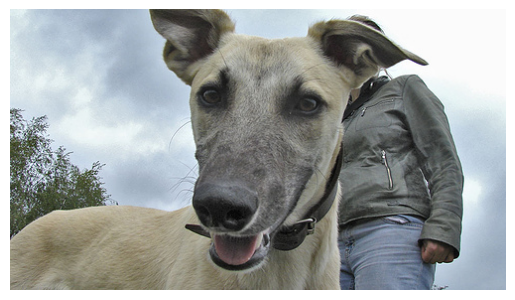

[80] <class 'int'>
CPU times: total: 703 ms
Wall time: 2.85 s


In [3]:
%%time
# TODO: Run an prediction on the endpoint
# TODO: Your code to load and preprocess image to send to endpoint for prediction
import matplotlib.pyplot as plt
from matplotlib.image import imread
image_path = "data\dogs\Greyhound_05496.jpg"
image = imread(image_path)
print(image.shape)
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

import json
import base64
# CONTENT_TYPE = 'application/json'
# ACCEPT = 'application/json'
with open(image_path, "rb") as f:
    payload = json.dumps(
        base64.b64encode(f.read()).decode('utf-8')
    )
response = predictor.predict(payload)
print(response, type(response[0]))

* Randomly get a dog image from the test folder in the s3 bucket and check the accuracy

In [4]:
## get labels (folder names)
import boto3
def get_label_dict(bucket_name, base_prefix=None):
    label_dict = dict()
    s3_client = boto3.client('s3')
    # Set delimiter to '/' to treat paths as folders
    params = {
        'Bucket': bucket_name,
        'Delimiter': '/'
    }
    if base_prefix:
        params['Prefix'] = base_prefix if base_prefix.endswith('/') else base_prefix + '/'
    result = s3_client.list_objects_v2(**params)
    # Check if CommonPrefixes exists, which represents folders in S3
    if 'CommonPrefixes' in result:
        for prefix in result['CommonPrefixes']:
            key, val = prefix.get('Prefix').split('/')[-2].split('.')
            label_dict[int(key)] = val
    else:
        print("⚠️ No folders found in this prefix.")
    return label_dict

# Example usage
bucket_name = 'p3-dog-breed-image-classification'
base_prefix = 'dogImages/train'  # Specify the layer of prefix you want to read
label_dict = get_label_dict(bucket_name, base_prefix)
print(f"There are {len(label_dict)} dog breeds in total in the dataset.")


[12/06/24 03:55:05] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=43324;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=666497;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

There are 133 dog breeds in total in the dataset.


Random object: 'dogImages/test/019.Bedlington_terrier/Bedlington_terrier_01369.jpg'
Downloaded as: 'data\dogs\Bedlington_terrier_01369.jpg'
🟢 Prediction '19 Bedlington_terrier' is CORRECT.
(333, 500, 3)


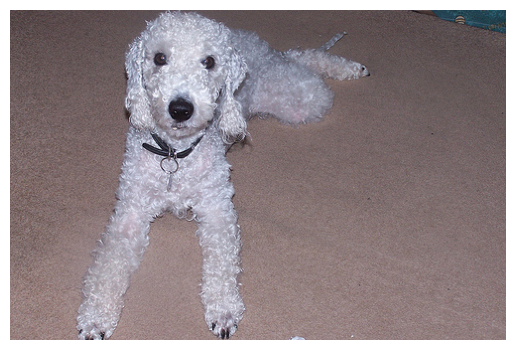

File 'data\dogs\Bedlington_terrier_01369.jpg' deleted successfully


In [47]:
## randomly get a dog image from the test folder in the s3 bucket
import boto3
import random
import json 
import base64
s3_client = boto3.client('s3')
bucket = 'p3-dog-breed-image-classification'
prefix = 'dogImages/test/'
response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
# Check if there are objects in the folder
if 'Contents' in response:
    # Extract object keys (file names)
    object_keys = [obj['Key'] for obj in response['Contents']]
    # Select a random object
    random_object = random.choice(object_keys)
    label = int(random_object.split('/')[2].split('.')[0])
    # Print the random object key
    print(f"Random object: '{random_object}'")
    # Download the random object (optional)
    local_object = "data\dogs\\"+random_object.split('/')[-1]
    s3_client.download_file(bucket, random_object, local_object)
    print(f"Downloaded as: '{local_object}'")
else:
    print("⚠️ No objects found in the specified folder.")

## predict
with open(local_object, "rb") as f:
    payload = json.dumps(
        base64.b64encode(f.read()).decode('utf-8')
    )
response = predictor.predict(payload)
predicted_label = response[0]+1
if predicted_label==label:
    print(f"🟢 Prediction '{predicted_label} {label_dict[predicted_label]}' is CORRECT.")
else:
    print(f"🔴 Prediction '{predicted_label} {label_dict[predicted_label]}' is WRONG.")

## display image
import matplotlib.pyplot as plt
from matplotlib.image import imread
img = imread(local_object)
print(img.shape)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

## delete image
import os
if os.path.exists(local_object):
    os.remove(local_object)
    print(f"File '{local_object}' deleted successfully")

* Check [the endpoint](https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints) (AWS SageMaker)
* Check [the endpoint logs](https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logsV2:log-groups/log-group/%2Faws%2Fsagemaker%2FEndpoints%2Fp3-dog-breed-classification) (AWS CloudWatch)    
* Check [the endpoint folder](https://us-east-1.console.aws.amazon.com/s3/buckets/sagemaker-us-east-1-852125600954) (AWS S3)    

### **🏷️ Delete endpoint, model, log streams, s3 folder**    

In [48]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
import boto3
## delete the endpoint model
sm_client = boto3.client('sagemaker')
endpoint_info = sm_client.describe_endpoint(EndpointName=predictor.endpoint_name)
endpoint_config_name = endpoint_info['EndpointConfigName']
endpoint_config_info = sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
model_name = endpoint_config_info['ProductionVariants'][0]['ModelName']
sm_client.delete_model(ModelName=model_name)
print("🟢 Model deleted:", model_name)
## delete the endpoint
predictor.delete_endpoint()
print("🟢 Endpoint deleted:", predictor.endpoint_name)

🟢 Model deleted: pytorch-inference-2024-12-06-09-48-17-235


[12/06/24 03:59:57] INFO     Deleting endpoint configuration with name: p3-dog-breed-classification ]8;id=853515;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=602834;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#4796\4796]8;;\

                    INFO     Deleting endpoint with name: p3-dog-breed-classification               ]8;id=414525;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=530649;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#4786\4786]8;;\

🟢 Endpoint deleted: p3-dog-breed-classification


In [49]:
## clear the sagemaker default bucket where stores the deployable model created by the endpoint
!aws s3 rm s3://sagemaker-us-east-1-852125600954 --recursive

delete: s3://sagemaker-us-east-1-852125600954/pytorch-inference-2024-12-06-09-46-52-202/model.tar.gz


In [50]:
import boto3
def delete_log_streams(s3_client_logs, log_group_name):
    # Retrieve log streams from the specified log group
    log_streams = s3_client_logs.describe_log_streams(logGroupName=log_group_name)
    # Iterate through each log stream and delete it
    for stream in log_streams['logStreams']:
        log_stream_name = stream['logStreamName']
        print(f"Deleting log stream: {log_stream_name}...")
        s3_client_logs.delete_log_stream(logGroupName=log_group_name, logStreamName=log_stream_name)
    print(f"🟢 All log streams deleted from log group: {log_group_name}")

s3_client_logs = boto3.client('logs')
log_group_name = "/aws/sagemaker/Endpoints/p3-dog-breed-classification"
delete_log_streams(s3_client_logs, log_group_name)

Deleting log stream: AllTraffic/i-037ce3444d773393a...
Deleting log stream: AllTraffic/i-0d22996b14f695b08...
🟢 All log streams deleted from log group: /aws/sagemaker/Endpoints/p3-dog-breed-classification
